In [5]:
import pandas as pd
from datetime import datetime
!pip install sodapy
!pip install folium
!pip install plotly
!pip install seaborn
!pip install altair
from sodapy import Socrata
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from functools import reduce
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import folium.plugins as plugins  
from folium import Map
from folium import features
import altair as alt
import json


import warnings
warnings.filterwarnings('ignore')

In [176]:
!pip install folium --upgrade

In [1]:
!ls

drive  sample_data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [6]:
#Read and view AFL Data
afl_df = pd.read_csv('/content/drive/MyDrive/afl_data.csv')
afl_df.head()

,gameId,year,round,date,venue,startTime,attendance,homeTeam,awayTeam,rainfall
0,2022R504,2022,R4,10-Apr-22,M.C.G.,15:20,30926,Hawthorn,St Kilda,0.0
1,2022R403,2022,R4,10-Apr-22,Docklands,13:10,24906,Essendon,Adelaide,0.0
2,2022R402,2022,R4,09-Apr-22,M.C.G.,19:25,43645,Richmond,Western Bulldogs,0.0
3,2022R401,2022,R4,09-Apr-22,Docklands,16:35,25897,Collingwood,West Coast,0.0
4,2022R305,2022,R3,03-Apr-22,Docklands,15:20,31933,St Kilda,Richmond,1.8


In [7]:
#Standardise the datatime data
afl_df['startTime'] = pd.to_datetime(afl_df['startTime'], format = '%H:%M')

afl_df.date = pd.to_datetime(afl_df.date, format = '%d-%b-%y')
afl_df['day_of_week'] = afl_df['date'].dt.day_name()

afl_df['StartHour'] = pd.to_datetime(afl_df['startTime'], format='%H:%M:%S').dt.hour
afl_df['StartMinute'] = pd.to_datetime(afl_df['startTime'], format='%H:%M:%S').dt.minute

In [8]:
#Generate start time categories
afl_df['timeslot'] = pd.to_datetime(afl_df['startTime'])
afl_df['timeslot'] = afl_df['timeslot'].dt.strftime("%H:%M:%S")
afl_df['timeslot'] = afl_df['timeslot'].apply(lambda x: 'Afternoon' if x <= '16:00:00' else 'Evening')
afl_df['start'] = afl_df['startTime'].dt.strftime("%H-%M-%S")

## Extract game date data

In [9]:
game_dates_list = pd.unique((afl_df.date).dt.strftime('%Y-%m-%d')).tolist()

afternoons_dates = afl_df[(afl_df.timeslot == 'Afternoon')]
afternoons_dates_list = pd.unique((afternoons_dates.date).dt.strftime('%Y-%m-%d')).tolist()

evening_dates = afl_df[(afl_df.timeslot == 'Evening')]
evening_dates_list = pd.unique((evening_dates.date).dt.strftime('%Y-%m-%d')).tolist()


MCG_dates = afl_df[(afl_df.venue == 'M.C.G.')]
MCG_dates_list = pd.unique((MCG_dates.date).dt.strftime('%Y-%m-%d')).tolist()

Docklands_dates = afl_df[(afl_df.timeslot == 'Docklands')]
Docklands_dates_list = pd.unique((Docklands_dates.date).dt.strftime('%Y-%m-%d')).tolist()

In [10]:
#Pedestrian data
client = Socrata('data.melbourne.vic.gov.au', 'jkWLqYGpmFN5bK6j45TU4peYP', None)
results = client.get("b2ak-trbp", limit=7000000)

pedestrian_df = pd.DataFrame.from_records(results)
#pedestrian_df['sensor_id'] = pedestrian_df['sensor_id'].astype(int)

In [11]:
#View pedestrian data
pedestrian_df.head(5).T

,0,1,2,3,4
id,2887628,2887629,2887630,2887631,2887632
date_time,2019-11-01T17:00:00.000,2019-11-01T17:00:00.000,2019-11-01T17:00:00.000,2019-11-01T17:00:00.000,2019-11-01T17:00:00.000
year,2019,2019,2019,2019,2019
month,November,November,November,November,November
mdate,1,1,1,1,1
day,Friday,Friday,Friday,Friday,Friday
time,17,17,17,17,17
sensor_id,34,39,37,40,36
sensor_name,Flinders St-Spark La,Alfred Place,Lygon St (East),Lonsdale St-Spring St (West),Queen St (West)
hourly_counts,300,604,216,627,774


In [12]:
#Location data
client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
ped_data_location = "h57g-5234"
results = client.get(ped_data_location)
sensor_location = pd.DataFrame.from_records(results)
sensor_location[['latitude', 'longitude']] = sensor_location[['latitude', 'longitude']].astype(float)
#sensor_location['sensor_id'] = sensor_location['sensor_id'].astype(str)

In [13]:
#View sensor data
sensor_location.head(5).T

,0,1,2,3,4
sensor_id,55,45,61,7,72
sensor_description,Elizabeth St-La Trobe St (East),Little Collins St-Swanston St (East),RMIT Building 14,Birrarung Marr,Flinders St- ACMI
sensor_name,Eli380_T,Swa148_T,RMIT14_T,Fed_T,ACMI_T
installation_date,2018-07-19T00:00:00.000,2017-06-29T00:00:00.000,2019-06-28T00:00:00.000,2014-12-17T00:00:00.000,2020-11-30T00:00:00.000
status,A,A,A,A,A
direction_1,North,North,North,East,East
direction_2,South,South,South,West,West
latitude,-37.809889,-37.814141,-37.807675,-37.818629,-37.817263
longitude,144.961343,144.966094,144.963091,144.971694,144.968728
location,"{'latitude': '-37.80988941', 'longitude': '144...","{'latitude': '-37.81414074', 'longitude': '144...","{'latitude': '-37.80767455', 'longitude': '144...","{'latitude': '-37.81862929', 'longitude': '144...","{'latitude': '-37.81726337', 'longitude': '144..."


In [14]:
sensor_location.dtypes

sensor_id              object
sensor_description     object
sensor_name            object
installation_date      object
status                 object
direction_1            object
direction_2            object
latitude              float64
longitude             float64
location               object
note                   object
dtype: object

In [15]:
#Plot location of sensors

map = folium.Map(location=[sensor_location.latitude.mean(), 
                           sensor_location.longitude.mean()], 
                          zoom_start=14, min_zoom=14, max_zoom = 16,max_bounds=True)

for i in range(0,len(sensor_location)):
    folium.Marker(location = [sensor_location.iloc[i]['latitude'], 
                            sensor_location.iloc[i]['longitude']], 
                            popup = sensor_location.iloc[i]['sensor_id'],).add_to(map)

map

In [16]:
#best_sensor_location = sensor_location[sensor_location.sensor_id.isin([9,10,2,6,18,8,11,1,5,12,3,14,31,13])]


map = folium.Map(location=[sensor_location.latitude.mean(), 
                           sensor_location.longitude.mean()], 
                          zoom_start=14, control_scale=True)

for i in range(0,len(sensor_location)):
    folium.Marker(location = [sensor_location.iloc[i]['latitude'], 
                            sensor_location.iloc[i]['longitude']], 
                            popup = sensor_location.iloc[i]['sensor_id'],).add_to(map)
map


## Merge dataframes

In [17]:
pedestrian_df.dtypes

id               object
date_time        object
year             object
month            object
mdate            object
day              object
time             object
sensor_id        object
sensor_name      object
hourly_counts    object
dtype: object

In [18]:
merged_df = pd.merge(pedestrian_df, sensor_location, on = 'sensor_id')

In [19]:
merged_df = merged_df[['date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id',
       'sensor_name_x', 'hourly_counts','latitude',
       'longitude']]

In [20]:
merged_df['date_time'] = pd.to_datetime(merged_df['date_time'])
merged_df['date'] = merged_df['date_time'].dt.strftime("%Y-%m-%d")

In [21]:
merged_df = merged_df.sort_values(['date_time'], ascending = True)
merged_df['hourly_counts'] = merged_df['hourly_counts'].astype(int)
merged_df['day'] = merged_df['day'].astype(str)

In [24]:
#merged_df['date_time'] = pd.to_datetime(merged_df['date_time'])
merged_df['year'] = merged_df['year'].astype(int)
merged_df['mdate'] = merged_df['mdate'].astype(int)
merged_df['time'] = merged_df['time'].astype(int)
merged_df['hourly_counts'] = merged_df['hourly_counts'].astype(int)
merged_df['year'] = merged_df['year'].astype(int)
merged_df['sensor_id'] = merged_df['sensor_id'].astype(int)

In [23]:
#adjust dataframe to AFL data
merged_df.reset_index(inplace =True)
merged_df = merged_df[merged_df.date > '2012-03-29']

merged_df2 = merged_df.copy()

In [25]:
merged_df.sensor_id.value_counts().sort_values(ascending = False).head(12)

9     87688
10    87561
2     87451
6     87257
18    86511
8     86233
11    86172
1     85099
5     84332
12    84181
3     82714
14    81570
Name: sensor_id, dtype: int64

In [26]:
#Extract game and and non game data
afl_df = merged_df[merged_df['date'].isin(game_dates_list)]
non_afl_df = merged_df[~merged_df['date'].isin(game_dates_list)]

In [27]:
afl_df.head()

,index,date_time,year,month,mdate,day,time,sensor_id,sensor_name_x,hourly_counts,latitude,longitude,date
441888,2744698,2012-03-30,2012,March,30,Friday,0,6,Flinders Street Station Underpass,213,-37.819117,144.965583,2012-03-30
441889,1983015,2012-03-30,2012,March,30,Friday,0,9,Southern Cross Station,17,-37.819830,144.951026,2012-03-30
441890,3858924,2012-03-30,2012,March,30,Friday,0,13,Flagstaff Station,30,-37.812397,144.956527,2012-03-30
441891,1665565,2012-03-30,2012,March,30,Friday,0,1,Bourke Street Mall (North),90,-37.813494,144.965153,2012-03-30
441892,1286796,2012-03-30,2012,March,30,Friday,0,17,Collins Place (South),69,-37.813625,144.973236,2012-03-30


In [28]:
non_afl_df.head()

,index,date_time,year,month,mdate,day,time,sensor_id,sensor_name_x,hourly_counts,latitude,longitude,date
443184,2095894,2012-04-02,2012,April,2,Monday,0,10,Victoria Point,11,-37.818765,144.947105,2012-04-02
443185,2207666,2012-04-02,2012,April,2,Monday,0,12,New Quay,11,-37.814580,144.942924,2012-04-02
443186,3858996,2012-04-02,2012,April,2,Monday,0,13,Flagstaff Station,9,-37.812397,144.956527,2012-04-02
443187,2318730,2012-04-02,2012,April,2,Monday,0,11,Waterfront City,6,-37.815650,144.939707,2012-04-02
443188,2535098,2012-04-02,2012,April,2,Monday,0,7,Birrarung Marr,12,-37.818629,144.971694,2012-04-02


In [29]:
#Generate average pedestraian movements per hour
afl = pd.DataFrame(afl_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
afl.reset_index(inplace = True)

non_afl = pd.DataFrame(non_afl_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
non_afl.reset_index(inplace = True)

In [30]:
merged_df.sensor_id.value_counts()

9     87688
10    87561
2     87451
6     87257
18    86511
      ...  
77     8040
78     8040
79     4703
73     3648
60     2291
Name: sensor_id, Length: 78, dtype: int64

In [31]:
#Combine AFL and Non-AFL Data
merged_data= non_afl.merge(afl, on=["sensor_id","year", "day", "time"])
merged_data.drop(['latitude_x', 'longitude_x'], axis=1, inplace=True)
merged_data = merged_data.rename(columns = {'latitude_y':'latitude','longitude_y':'longitude' })
merged_data = merged_data.rename(columns = {'hourly_counts_x':'No_AFL','hourly_counts_y':'AFL' })

merged_data_diff = merged_data.copy()
merged_data_diff['diff'] = merged_data.AFL - merged_data.No_AFL
#merged_data_diff['diff'] = merged_data_diff['diff'].astype(float)
#merged_df2 = merged_data.copy()
#merged_data.drop(['latitude', 'longitude'], axis=1, inplace=True)

#merged_data_diff['diff'] = (merged_data_diff['diff']-merged_data_diff['diff'].min())/(merged_data_diff['diff'].max()-merged_data_diff['diff'].min()


In [32]:
merged_data = merged_data.rename(columns = {'hourly_counts_x':'No_AFL','hourly_counts_y':'AFL' })
merged_data

,sensor_id,year,day,time,No_AFL,latitude,longitude,AFL
0,1,2012,Friday,0,100.666667,-37.813494,144.965153,57.736842
1,1,2012,Friday,1,53.476190,-37.813494,144.965153,37.684211
2,1,2012,Friday,2,30.523810,-37.813494,144.965153,22.157895
3,1,2012,Friday,3,23.428571,-37.813494,144.965153,16.000000
4,1,2012,Friday,4,19.428571,-37.813494,144.965153,14.368421
...,...,...,...,...,...,...,...,...
61645,79,2022,Wednesday,19,440.800000,-37.817940,144.966167,580.000000
61646,79,2022,Wednesday,20,379.000000,-37.817940,144.966167,415.000000
61647,79,2022,Wednesday,21,377.200000,-37.817940,144.966167,495.000000
61648,79,2022,Wednesday,22,293.100000,-37.817940,144.966167,1263.000000


In [33]:
merged_data_diff = merged_data.copy()
merged_data_diff['diff'] = (merged_data.AFL - merged_data.No_AFL)/merged_data.AFL
merged_data_diff

,sensor_id,year,day,time,No_AFL,latitude,longitude,AFL,diff
0,1,2012,Friday,0,100.666667,-37.813494,144.965153,57.736842,-0.743543
1,1,2012,Friday,1,53.476190,-37.813494,144.965153,37.684211,-0.419061
2,1,2012,Friday,2,30.523810,-37.813494,144.965153,22.157895,-0.377559
3,1,2012,Friday,3,23.428571,-37.813494,144.965153,16.000000,-0.464286
4,1,2012,Friday,4,19.428571,-37.813494,144.965153,14.368421,-0.352172
...,...,...,...,...,...,...,...,...,...
61645,79,2022,Wednesday,19,440.800000,-37.817940,144.966167,580.000000,0.240000
61646,79,2022,Wednesday,20,379.000000,-37.817940,144.966167,415.000000,0.086747
61647,79,2022,Wednesday,21,377.200000,-37.817940,144.966167,495.000000,0.237980
61648,79,2022,Wednesday,22,293.100000,-37.817940,144.966167,1263.000000,0.767933


In [34]:
merged_data = merged_data.melt(["sensor_id", "year", "day", "time", "latitude", "longitude"],var_name="AFL",value_name="PedestrianCount")
merged_data

,sensor_id,year,day,time,latitude,longitude,AFL,PedestrianCount
0,1,2012,Friday,0,-37.813494,144.965153,No_AFL,100.666667
1,1,2012,Friday,1,-37.813494,144.965153,No_AFL,53.476190
2,1,2012,Friday,2,-37.813494,144.965153,No_AFL,30.523810
3,1,2012,Friday,3,-37.813494,144.965153,No_AFL,23.428571
4,1,2012,Friday,4,-37.813494,144.965153,No_AFL,19.428571
...,...,...,...,...,...,...,...,...
123295,79,2022,Wednesday,19,-37.817940,144.966167,AFL,580.000000
123296,79,2022,Wednesday,20,-37.817940,144.966167,AFL,415.000000
123297,79,2022,Wednesday,21,-37.817940,144.966167,AFL,495.000000
123298,79,2022,Wednesday,22,-37.817940,144.966167,AFL,1263.000000


In [35]:
#Check for duplicate dates
list1 = afl_df.date_time
list2 = non_afl_df.date_time

if any(x in list1 for x in list2):
    print("Duplicates found.")
else:
    print("No duplicates found.")

No duplicates found.


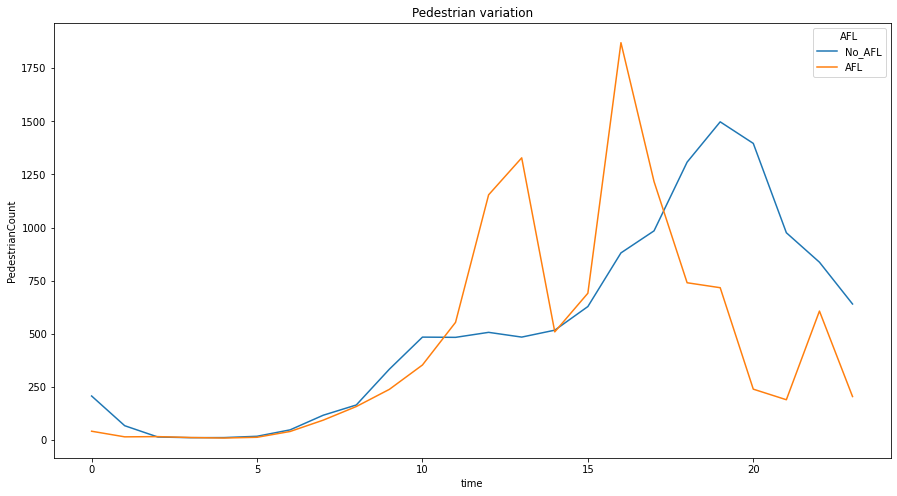

In [149]:
#Plot afl v non-afl movmeents, enter sensor_id, year and day of the week

plt.figure(figsize=(15,8))
sns.lineplot(x='time', y='PedestrianCount', hue='AFL', 
             data = merged_data[(merged_data.sensor_id == 7) & 
                                (merged_data.year == 2019) & 
                                (merged_data.day == 'Saturday')]).set_title('Pedestrian variation')

plt.show()

In [150]:
def PedestrianVar(year, day, *sensor_ids):
  m = folium.Map(location=[sensor_location.latitude.mean(), 
                            sensor_location.longitude.mean()], 
                            zoom_start=14, control_scale=True, min_zoom=14, max_zoom = 16)

  for i in sensor_ids:
    data = merged_data[(merged_data.sensor_id == i) & 
                                (merged_data.year == 2019) & 
                                (merged_data.day == 'Saturday')]

    pedestrian_chart = alt.Chart(data).mark_line().encode(
      x='time',
      y='PedestrianCount',
      color='AFL')
    
    chart = json.loads(pedestrian_chart.to_json())

    popup = folium.Popup(max_width=350)
    folium.features.VegaLite(chart, height=200, width=350).add_to(popup)
    folium.Marker([data.iloc[i]['latitude'], 
                              data.iloc[i]['longitude']], tooltip = data.iloc[i]['sensor_id'], popup=popup).add_to(m)

  return(m)

In [151]:
pedestrian_variance = PedestrianVar(2014, 'Sunday',7,9,10,2,6,18,8,11,1,5)
pedestrian_variance

**Differentiate between start times, before 4pm is Afternoon, after 4pm is considered evening.**

In [152]:
#Extract afternoon and evening data
afl_afternoon_df = afl_df[afl_df['date'].isin(afternoons_dates_list)]
afl_evening_df = afl_df[~afl_df['date'].isin(afternoons_dates_list)]

afl_afternoon_df2 = pd.DataFrame(afl_afternoon_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
afl_afternoon_df2.reset_index(inplace = True)

afl_evening_df2 = pd.DataFrame(afl_evening_df.groupby(['sensor_id', 'year', 'day','time','latitude', 'longitude'])['hourly_counts'].mean())
afl_evening_df2.reset_index(inplace = True)
#non_afl.drop(['latitude', 'longitude'], axis=1, inplace=True)
dfs = [afl_evening_df2,afl_afternoon_df2,non_afl]

In [153]:
final_df = reduce(lambda  left,right: pd.merge(left,right,on=["sensor_id", "year", "day", "time"],
                                            how='outer'), dfs)
final_df = final_df.rename(columns = {'hourly_counts_x':'Evening','hourly_counts_y':'Afternoon', 'hourly_counts': 'No AFL'})
final_df.drop(['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y'], axis=1, inplace=True)
time_merged_data = final_df.melt(["sensor_id", "year", "day", "time", "latitude", "longitude"],var_name="AFL",value_name="hourly_counts")


In [95]:
time_merged_data

,sensor_id,year,day,time,latitude,longitude,AFL,hourly_counts
0,1,2012,Friday,0,-37.813494,144.965153,Evening,57.736842
1,1,2012,Friday,1,-37.813494,144.965153,Evening,37.684211
2,1,2012,Friday,2,-37.813494,144.965153,Evening,22.157895
3,1,2012,Friday,3,-37.813494,144.965153,Evening,16.000000
4,1,2012,Friday,4,-37.813494,144.965153,Evening,14.368421
...,...,...,...,...,...,...,...,...
273019,79,2022,Tuesday,19,-37.817940,144.966167,No AFL,416.916667
273020,79,2022,Tuesday,20,-37.817940,144.966167,No AFL,356.916667
273021,79,2022,Tuesday,21,-37.817940,144.966167,No AFL,341.750000
273022,79,2022,Tuesday,22,-37.817940,144.966167,No AFL,282.416667


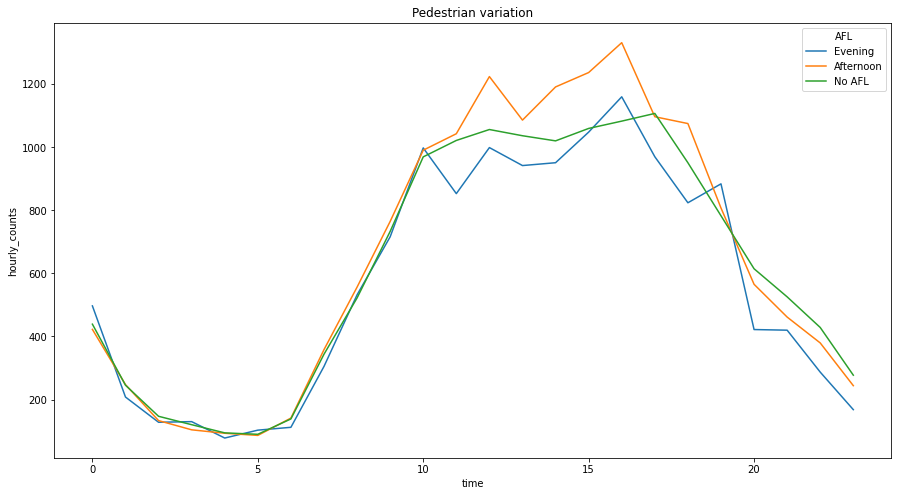

In [96]:
#Plot non-afl v afternoon v evening movements, enter sensor_id, year and day of the week


plt.figure(figsize=(15,8))
sns.lineplot(x='time', y='hourly_counts', hue='AFL', 
             data = time_merged_data[(time_merged_data.sensor_id == 24) & 
                                (time_merged_data.year == 2016) & 
                                (time_merged_data.day == 'Sunday')]).set_title('Pedestrian variation')

plt.show()

In [97]:
def TimeVar(year, day, *sensor_ids):

  m = folium.Map(location=[sensor_location.latitude.mean(), 
                            sensor_location.longitude.mean()], 
                            zoom_start=15, control_scale=False, min_zoom=14, max_zoom = 16)

  for i in sensor_ids:
    data = time_merged_data[(time_merged_data.sensor_id == i) & 
                                (time_merged_data.year == 2016) & 
                                (time_merged_data.day == 'Sunday')]

    pedestrian_chart = alt.Chart(data).mark_line().encode(
      x='time',
      y='hourly_counts',
      color='AFL')
    
    chart = json.loads(pedestrian_chart.to_json())

    popup = folium.Popup(max_width=350)
    folium.features.VegaLite(chart, height=200, width=350).add_to(popup)
    folium.Marker([data.iloc[i]['latitude'], 
                              data.iloc[i]['longitude']], tooltip = data.iloc[i]['sensor_id'], popup=popup).add_to(m)

  return(m)


In [98]:
PedestrianVariance = TimeVar(2014, 'Sunday',7,9,10,2,6,18,8,11,1,5,12,3,14,31,13)
PedestrianVariance

**Differentiate between grounds, MCG or Docklands.**

In [99]:
#Extract ground data
afl_mcg_df = afl_df[afl_df['date'].isin(MCG_dates_list)]
afl_docklands_df = afl_df[~afl_df['date'].isin(MCG_dates_list)]

afl_mcg_df2 = pd.DataFrame(afl_mcg_df.groupby(['sensor_id', 'year', 'day','time','latitude', 'longitude'])['hourly_counts'].mean())
afl_mcg_df2.reset_index(inplace = True)

afl_docklands_df2 = pd.DataFrame(afl_docklands_df.groupby(['sensor_id', 'year', 'day','time', 'latitude', 'longitude'])['hourly_counts'].mean())
afl_docklands_df2.reset_index(inplace = True)

dfs = [afl_mcg_df2,afl_docklands_df2,non_afl]

In [100]:
final_df = reduce(lambda  left,right: pd.merge(left,right,on=["sensor_id", "year", "day", "time"],
                                            how='outer'), dfs)
final_df = final_df.rename(columns = {'hourly_counts_x':'MCG','hourly_counts_y':'Docklands', 'hourly_counts': 'No AFL'})
final_df.drop(['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y'], axis=1, inplace=True)
time_merged_data = final_df.melt(["sensor_id", "year", "day", "time", "latitude", "longitude"],var_name="AFL",value_name="hourly_counts")


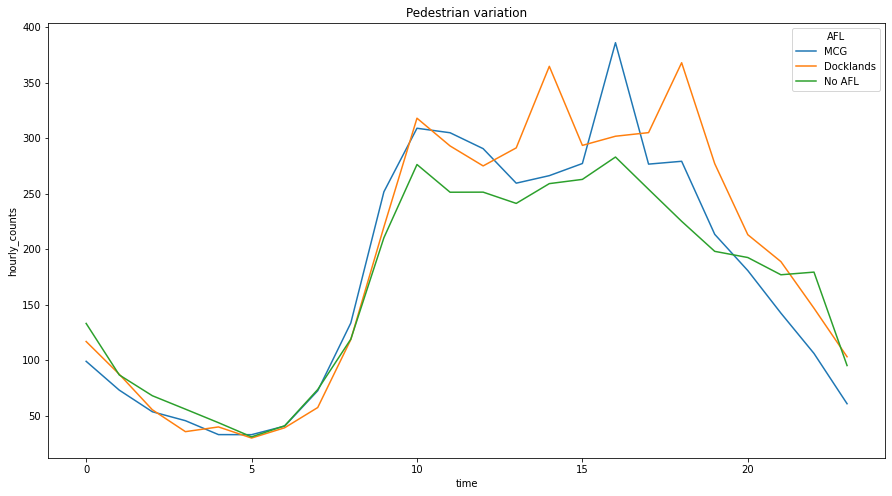

In [101]:
#Plot non-afl v afternoon v evening movements, enter sensor_id, year and day of the week


plt.figure(figsize=(15,8))
sns.lineplot(x='time', y='hourly_counts', hue='AFL', 
             data = time_merged_data[(time_merged_data.sensor_id == 23) & 
                                (time_merged_data.year == 2017) & 
                                (time_merged_data.day == 'Sunday')]).set_title('Pedestrian variation')

plt.show()

In [102]:
def GroundVar(year, day, *sensor_ids):
  m = folium.Map(location=[sensor_location.latitude.mean(), 
                            sensor_location.longitude.mean()], 
                            zoom_start=13, control_scale=True, min_zoom=14, max_zoom = 16)

  for i in sensor_ids:
    data = time_merged_data[(time_merged_data.sensor_id == i) & 
                                (time_merged_data.year == 2016) & 
                                (time_merged_data.day == 'Saturday')]

    pedestrian_chart = alt.Chart(data).mark_line().encode(
      x='time',
      y='hourly_counts',
      color='AFL')
    
    chart = json.loads(pedestrian_chart.to_json())

    popup = folium.Popup(max_width=350)
    folium.features.VegaLite(chart, height=200, width=350).add_to(popup)
    folium.Marker([data.iloc[i]['latitude'], 
                              data.iloc[i]['longitude']], tooltip = data.iloc[i]['sensor_id'], popup=popup).add_to(m)

  return(m)

In [103]:
PedestrianVariance = GroundVar(2014, 'Sunday',7,9,10,2,6,18,8,11,1,5,12,3,14,31,13)
PedestrianVariance

In [164]:
merged_data_diff2 = merged_data_diff[(merged_data_diff.year == 2013) & (merged_data_diff.day == 'Friday')]
merged_data_diff2

,sensor_id,year,day,time,No_AFL,latitude,longitude,AFL,diff
120,1,2013,Friday,0,110.794118,-37.813494,144.965153,88.944444,-21.849673
121,1,2013,Friday,1,66.117647,-37.813494,144.965153,47.944444,-18.173203
122,1,2013,Friday,2,41.058824,-37.813494,144.965153,24.222222,-16.836601
123,1,2013,Friday,3,28.470588,-37.813494,144.965153,20.722222,-7.748366
124,1,2013,Friday,4,21.794118,-37.813494,144.965153,15.055556,-6.738562
...,...,...,...,...,...,...,...,...,...
33206,28,2013,Friday,19,1571.357143,-37.821299,144.968793,1457.000000,-114.357143
33207,28,2013,Friday,20,759.071429,-37.821299,144.968793,373.000000,-386.071429
33208,28,2013,Friday,21,1050.500000,-37.821299,144.968793,322.000000,-728.500000
33209,28,2013,Friday,22,918.000000,-37.821299,144.968793,1417.000000,499.000000


In [161]:
np.max(merged_data_diff['diff'])

0.8681781483846869

In [169]:
#merged_data_diff = merged_data_diff[(merged_data_diff.year == 2015) & (merged_data_diff.day == 'Friday')]

data = []
for _, d in merged_data_diff2.groupby('time'):
    data.append([[row['latitude'], row['longitude'], row['diff']] for _, row in d.iterrows()])

time_index = [k[0] for k in merged_data_diff2.groupby('time')]

In [170]:
m= folium.Map(location=[sensor_location.latitude.mean(), 
                           sensor_location.longitude.mean()], 
                            zoom_start=14)


HeatMapWithTime(data, index = time_index, name = 'Heat Map', auto_play=True, min_opacity = .5, radius=20, overlay = True).add_to(m)
m

In [154]:
merged_data_diff2

,sensor_id,year,day,time,No_AFL,latitude,longitude,AFL,diff


In [42]:
merged_data_diff2 = merged_data_diff[(merged_data_diff.year == 2019) & (merged_data_diff.day == 'Saturday')]


data = []
for _, d in merged_data_diff2.groupby('time'):
    data.append([[row['latitude'], row['longitude'], row['diff']] for _, row in d.iterrows()])

time_index = [k[0] for k in merged_data_diff2.groupby('time')]

In [43]:
m= folium.Map(location=[sensor_location.latitude.mean(), 
                           sensor_location.longitude.mean()],
                            zoom_start=14)


hm = HeatMapWithTime(data, index = time_index, name = 'Heat Map',auto_play=True, 
                min_opacity=.5, 
                gradient = {0.05: 'blue', 
                            0.1: 'green', 
                            0.2: 'orange', 
                            0.5: 'red'}).add_to(m)
m

In [174]:
merged_data_diff2

,sensor_id,year,day,time,No_AFL,latitude,longitude,AFL,diff
432,1,2015,Sunday,0,286.833333,-37.813494,144.965153,215.142857,-71.690476
433,1,2015,Sunday,1,217.375000,-37.813494,144.965153,147.428571,-69.946429
434,1,2015,Sunday,2,136.000000,-37.813494,144.965153,102.190476,-33.809524
435,1,2015,Sunday,3,107.083333,-37.813494,144.965153,86.095238,-20.988095
436,1,2015,Sunday,4,68.125000,-37.813494,144.965153,51.380952,-16.744048
...,...,...,...,...,...,...,...,...,...
47532,44,2015,Sunday,19,70.777778,-37.796905,144.964404,63.631579,-7.146199
47533,44,2015,Sunday,20,54.055556,-37.796905,144.964404,50.210526,-3.845029
47534,44,2015,Sunday,21,45.555556,-37.796905,144.964404,37.684211,-7.871345
47535,44,2015,Sunday,22,35.111111,-37.796905,144.964404,30.684211,-4.426901


In [112]:
merged_data_diff = merged_data_diff[(merged_data_diff.year == 2012) & (merged_data_diff.day == 'Saturday')]


data = []
for _, d in merged_data_diff.groupby('time'):
    data.append([[row['latitude'], row['longitude'], row['diff']] for _, row in d.iterrows()])

time_index = [k[0] for k in merged_data_diff.groupby('time')]

[]